## Packages & utils

In [78]:
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm
import holidays

from sklearn.metrics import mean_squared_error

fr_holidays = holidays.CountryHoliday('FRA')

from vacances_scolaires_france import SchoolHolidayDates
school_holidays = SchoolHolidayDates()

import cufflinks as cf
cf.go_offline()

## Données

In [79]:
nomenclature_produits = pd.read_csv('data/nomenclature_produits.csv')

points_de_vente = pd.read_csv('data/points_de_vente.csv')
prix_vente = pd.read_csv('data/prix_vente.csv')

prix_vente['ORD_PRIX'] = prix_vente['PRIX_UNITAIRE'].apply(lambda x: float(x.split(' ')[-1].replace('€', '')))

ventes_2018 = pd.read_csv('data/ventes_2018.csv.zip',
                          parse_dates=['DATE'])

## Dates

In [80]:
artc_list = ventes_2018['ID_ARTC'].drop_duplicates().tolist()

In [81]:
dates = pd.date_range('2017-12-01', '2019-04-30')
combines = pd.DataFrame(itertools.product(artc_list, dates),
                        columns=['ID_ARTC', 'DATE']
                        )

In [82]:
dates_dataframe = combines[['DATE']].drop_duplicates()
dates_dataframe['holiday_zone_A'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'A'))*1
dates_dataframe['holiday_zone_B'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'B'))*1
dates_dataframe['holiday_zone_C'] = dates_dataframe['DATE'].dt.date\
                                    .apply(lambda x: school_holidays.is_holiday_for_zone(x, 'C'))*1
dates_dataframe['free_days'] = dates_dataframe['DATE'].apply(lambda x: x in fr_holidays)
dates_dataframe['rolling_free_days'] = dates_dataframe['free_days'].rolling(7, center=True).mean()

dates_dataframe['flag_magasin_ferme'] = None
dates_dataframe['flag_magasin_ferme'] = dates_dataframe[['flag_magasin_ferme', 'DATE']]\
                                .apply(lambda x: 1 if x[1].month==12 and x[1].day==25 else x[0], axis=1)
dates_dataframe['flag_magasin_ferme'] = dates_dataframe[['flag_magasin_ferme', 'DATE']]\
                                .apply(lambda x: 1 if x[1].month==1 and x[1].day==1 else x[0], axis=1)
dates_dataframe['flag_magasin_ferme'] = dates_dataframe[['flag_magasin_ferme', 'DATE']]\
                                .apply(lambda x: 1 if x[1].month==5 and x[1].day==1 else x[0], axis=1)
dates_dataframe['flag_magasin_ferme'].fillna(0, inplace=True)

dates_dataframe = dates_dataframe[dates_dataframe['DATE'].dt.date<=pd.to_datetime("2019-03-31")]
dates_dataframe = dates_dataframe[dates_dataframe['DATE'].dt.date>=pd.to_datetime("2018-01-01")]

dates_dataframe['month'] = dates_dataframe['DATE'].dt.month
dates_dataframe['dayofweek'] = dates_dataframe['DATE'].dt.dayofweek

<AxesSubplot:xlabel='DATE'>

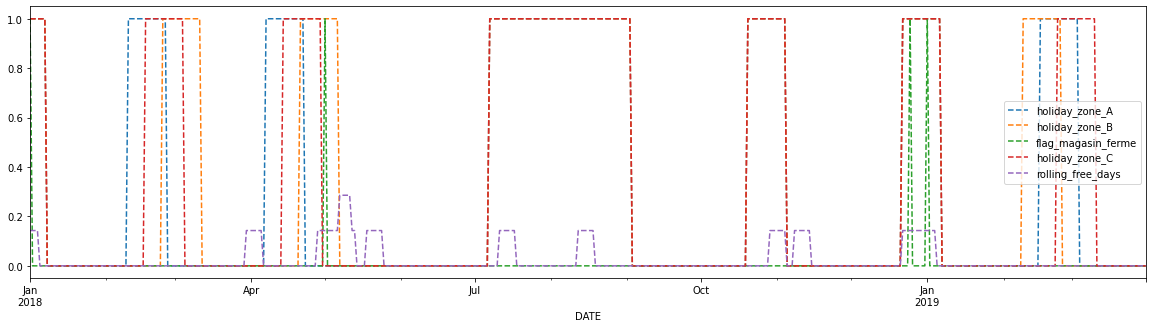

In [83]:
dates_dataframe.set_index('DATE')[
    ['holiday_zone_A', 'holiday_zone_B', 'flag_magasin_ferme',
     'holiday_zone_C', 'rolling_free_days']
].plot(figsize=(20, 5), style='--')

In [84]:
dates_dataframe['index'] = 1
nomenclature_produits['index'] = 1
nomenclature_produits_x_dates = nomenclature_produits.merge(dates_dataframe)
nomenclature_produits_x_dates.drop('index', axis=1, inplace=True)

In [148]:
def prepare_train_test_dataframes(ventes, nomenclature_produits_x_dates):
    ventes = ventes.merge(nomenclature_produits_x_dates, how='right')
    ventes['log_qte'] = np.log1p(ventes['QTE'].fillna(0))
    
    ventes['LB_VENT_FAML'] = ventes['LB_VENT_FAML'].astype('category')
    ventes['LB_VENT_SOUS_FAML'] = ventes['LB_VENT_SOUS_FAML'].astype('category')
    ventes['ID_ARTC'] = ventes['ID_ARTC'].astype('category')
    ventes['month'] = ventes['month'].astype('category')
    ventes['dayofweek'] = ventes['dayofweek'].astype('category')

    ventes['ID_ARTC'] = ventes['ID_ARTC'].astype('category')

    cols_to_keep = [
        'ID_ARTC', 'DATE',
        'holiday_zone_A', 'holiday_zone_B', 'holiday_zone_C',
        'free_days', 'rolling_free_days', 'flag_magasin_ferme',
        'month', 'dayofweek', 'LB_VENT_FAML', 'LB_VENT_SOUS_FAML',
        'log_qte'
    ]
    
    ventes = ventes[cols_to_keep]
    
    train = ventes[ventes['DATE'].dt.year==2018]
    test = ventes[ventes['DATE'].dt.year==2019]
    return train, test

In [200]:
test_list = list()

In [201]:
for pdv in tqdm(points_de_vente['ID_PDV'].tolist()):
    for rayon in tqdm(nomenclature_produits['LB_VENT_RAYN'].drop_duplicates().tolist()):
        
        sub_ventes = ventes_2018.query(f'ID_PDV=={pdv}').drop('ID_PDV', axis=1)
        sub_nomenclature_produits_x_dates = nomenclature_produits_x_dates.query(f'LB_VENT_RAYN=="{rayon}"')
        
        train, test = prepare_train_test_dataframes(sub_ventes, sub_nomenclature_produits_x_dates)
        
        model = lightgbm.LGBMRegressor(random_state=3105)
        model.fit(train.drop(['DATE', 'log_qte'], axis=1), train['log_qte'])
        test['log_qte'] = model.predict(test.drop(['DATE', 'log_qte'], axis=1)).clip(0)
        
        # set to 0 
        to_clean = train.groupby('ID_ARTC')['log_qte'].max().reset_index().query('log_qte==0')['ID_ARTC'].tolist()
        test.loc[test['ID_ARTC'].isin(to_clean),['log_qte']] = 0
        
        test['ID_PDV'] = pdv
        
        test_list.append(test)

 21%|██▏       | 3/14 [00:02<00:09,  1.15it/s]


 50%|█████     | 7/14 [00:03<00:03,  2.16it/s]


 79%|███████▊  | 11/14 [00:06<00:01,  1.98it/s]


 28%|██▊       | 41/149 [05:12<14:14,  7.91s/it]


 21%|██▏       | 3/14 [00:02<00:08,  1.24it/s]


 50%|█████     | 7/14 [00:03<00:03,  2.13it/s]


 79%|███████▊  | 11/14 [00:07<00:01,  1.96it/s]


 55%|█████▌    | 82/149 [10:26<09:33,  8.56s/it]


 21%|██▏       | 3/14 [00:02<00:08,  1.30it/s]


 50%|█████     | 7/14 [00:05<00:04,  1.62it/s]


 79%|███████▊  | 11/14 [00:10<00:02,  1.50it/s]


 83%|████████▎ | 123/149 [16:24<03:23,  7.81s/it]


 21%|██▏       | 3/14 [00:03<00:14,  1.34s/it]


 50%|█████     | 7/14 [00:04<00:03,  1.87it/s]


100%|██████████| 149/149 [19:49<00:00,  7.98s/it]


In [205]:
submission_file = pd.concat(test_list)

submission_file['raw_qte'] = np.expm1(submission_file['log_qte'].clip(0))
submission_file['qte'] = np.expm1(submission_file['log_qte'].clip(0)).round().astype(int)
submission_file['id'] = submission_file['ID_PDV'].astype(str) + "_" + \
                        submission_file['ID_ARTC'].astype(str) + '_' + \
                        submission_file['DATE'].dt.strftime('%Y%m%d').astype(str)

In [206]:
submission_file.query('qte!=0')[['id', 'qte']].to_csv('submit_rayon_pdv.csv.zip', index=False, compression="zip")

In [207]:
submission_file[['id', 'qte', 'raw_qte']].to_csv('submit_rayon_pdv_raw.csv.zip', index=False, compression="zip")